# Project - Deploying a Machine Learning Model on Heroku with FastAPI

## Data Description

### Source

This data was extracted from the census bureau database found at http://www.census.gov/ftp/pub/DES/www/welcome.html
```
Donor: Ronny Kohavi and Barry Becker,
       Data Mining and Visualization
       Silicon Graphics.
       e-mail: ronnyk@sgi.com for questions.
```
* Split into train-test using MLC++ GenCVFiles (2/3, 1/3 random).
* 48842 instances, mix of continuous and discrete    (train=32561, test=16281)
* 45222 if instances with unknown values are removed (train=30162, test=15060)
* Duplicate or conflicting instances : 6
* Class probabilities for adult.all file
  * Probability for the label '>50K'  : 23.93% / 24.78% (without unknowns)
  * Probability for the label '<=50K' : 76.07% / 75.22% (without unknowns)

For this project, only __train set__ of __unfiltered instanes__ is used - __32561 instances__.

### Objective
Prediction task is to determine whether a person makes over 50K a year.


### Transformations
Conversion of original data as follows:
1. Discretized gross income into two ranges with threshold 50,000.
2. Convert U.S. to US to avoid periods.
3. Convert Unknown to "?"
4. Run MLC++ GenCVFiles to generate data,test.


### Description of fnlwgt (final weight)
The weights on the CPS files are controlled to independent estimates of the
civilian noninstitutional population of the US.  These are prepared monthly
for us by Population Division here at the Census Bureau.  We use 3 sets of
controls.
These are:
1. A single cell estimate of the population 16+ for each state.
2. Controls for Hispanic Origin by age and sex.
3. Controls by Race, age and sex.
We use all three sets of controls in our weighting program and "rake" through
them 6 times so that by the end we come back to all the controls we used.
The term estimate refers to population totals derived from CPS by creating
"weighted tallies" of any specified socio-economic characteristics of the
population.

People with similar demographic characteristics should have
similar weights.  There is one important caveat to remember
about this statement.  That is that since the CPS sample is
actually a collection of 51 state samples, each with its own
probability of selection, the statement only applies within
state.

### Data values
| name | values |
|------|--------|
| __salary__ | >50K, <=50K.|
| age | continuous |
| workclass | Private, Self-emp-not-inc, Self-emp-inc, Federal-gov, Local-gov, State-gov, Without-pay, Never-worked |
| fnlwgt | continuous |
| education | Bachelors, Some-college, 11th, HS-grad, Prof-school, Assoc-acdm, Assoc-voc, 9th, 7th-8th, 12th, Masters, 1st-4th, 10th, Doctorate, 5th-6th, Preschool |
| education-num | continuous |
| marital-status | Married-civ-spouse, Divorced, Never-married, Separated, Widowed, Married-spouse-absent, Married-AF-spouse |
| occupation | Tech-support, Craft-repair, Other-service, Sales, Exec-managerial, Prof-specialty, Handlers-cleaners, Machine-op-inspct, Adm-clerical, Farming-fishing, Transport-moving, Priv-house-serv, Protective-serv, Armed-Forces |
| relationship | Wife, Own-child, Husband, Not-in-family, Other-relative, Unmarried |
| race | White, Asian-Pac-Islander, Amer-Indian-Eskimo, Other, Black |
| sex | Female, Male |
| capital-gain | continuous |
| capital-loss | continuous |
| hours-per-week | continuous |
| native-country | United-States, Cambodia, England, Puerto-Rico, Canada, Germany, Outlying-US(Guam-USVI-etc), India, Japan, Greece, South, China, Cuba, Iran, Honduras, Philippines, Italy, Poland, Jamaica, Vietnam, Mexico, Portugal, Ireland, France, Dominican-Republic, Laos, Ecuador, Taiwan, Haiti, Columbia, Hungary, Guatemala, Nicaragua, Scotland, Thailand, Yugoslavia, El-Salvador, Trinadad&Tobago, Peru, Hong, Holand-Netherlands |

## Getting raw data

In [1]:
import pandas as pd

In [2]:
DATA_PATH = '../data/census.csv'
df = pd.read_csv(DATA_PATH)
df.head()

age          workclass   fnlgt   education   education-num  \
0   39          State-gov   77516   Bachelors              13   
1   50   Self-emp-not-inc   83311   Bachelors              13   
2   38            Private  215646     HS-grad               9   
3   53            Private  234721        11th               7   
4   28            Private  338409   Bachelors              13   

        marital-status          occupation    relationship    race      sex  \
0        Never-married        Adm-clerical   Not-in-family   White     Male   
1   Married-civ-spouse     Exec-managerial         Husband   White     Male   
2             Divorced   Handlers-cleaners   Not-in-family   White     Male   
3   Married-civ-spouse   Handlers-cleaners         Husband   Black     Male   
4   Married-civ-spouse      Prof-specialty            Wife   Black   Female   

    capital-gain   capital-loss   hours-per-week  native-country  salary  
0           2174              0               40   United-States   <=50K  
1              0              0               13   United-States   <=50K  
2              0              0               40   United-States   <=50K  
3              0              0               40   United-States   <=50K  
4              0              0               40            Cuba   <=50K

## Initial ETL

### Remove trailing spaces

In [3]:
print(f'Trailing spaces: \n{df.columns.tolist()[:5]} ...')
def trim(dataset):
    trim = lambda x: x.strip() if type(x) is str else x
    dataset.columns = [trim(col) for col in dataset.columns]
    return dataset.applymap(trim)

df = trim(df)
print(f'Removing spaces: \n{df.columns.tolist()[:5]} ...')

Trailing spaces: 
['age', ' workclass', ' fnlgt', ' education', ' education-num'] ...
Removing spaces: 
['age', 'workclass', 'fnlgt', 'education', 'education-num'] ...


### Replace `?` with `Unknown` for readability

In [4]:
search_func_tmp = lambda row: row.astype(str).str.contains('?', regex = False).any()
df.loc[df.apply(search_func_tmp, axis=1)].head()

age workclass   fnlgt     education  education-num         marital-status  \
14   40   Private  121772     Assoc-voc             11     Married-civ-spouse   
27   54         ?  180211  Some-college             10     Married-civ-spouse   
38   31   Private   84154  Some-college             10     Married-civ-spouse   
51   18   Private  226956       HS-grad              9          Never-married   
61   32         ?  293936       7th-8th              4  Married-spouse-absent   

       occupation   relationship                race     sex  capital-gain  \
14   Craft-repair        Husband  Asian-Pac-Islander    Male             0   
27              ?        Husband  Asian-Pac-Islander    Male             0   
38          Sales        Husband               White    Male             0   
51  Other-service      Own-child               White  Female             0   
61              ?  Not-in-family               White    Male             0   

    capital-loss  hours-per-week native-country salary  
14             0              40              ?   >50K  
27             0              60          South   >50K  
38             0              38              ?   >50K  
51             0              30              ?  <=50K  
61             0              40              ?  <=50K

In [5]:
print(f'Number of rows containing `?`: {df.apply(search_func_tmp, axis=1).sum()}')
df.replace({'?': 'Unknown'}, inplace = True)
print(f'Number of rows containing `?` after replacement: {df.apply(search_func_tmp, axis=1).sum()}')


Number of rows containing `?`: 2399
Number of rows containing `?` after replacement: 0


## `pandas_profiling` for initial EDA

In [7]:
from pandas_profiling import ProfileReport

profile = ProfileReport(df, title="Pandas Profiling Report", explorative=True)
profile

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

## ETL (for baseline)

* Remove duplicates

In [8]:
df[df.duplicated(keep = False)].sort_values('fnlgt').head()

age         workclass  fnlgt     education  education-num  \
28846   39           Private  30916       HS-grad              9   
25624   39           Private  30916       HS-grad              9   
21875   49           Private  31267       7th-8th              4   
7920    49           Private  31267       7th-8th              4   
22494   49  Self-emp-not-inc  43479  Some-college             10   

           marital-status    occupation relationship   race   sex  \
28846  Married-civ-spouse  Craft-repair      Husband  White  Male   
25624  Married-civ-spouse  Craft-repair      Husband  White  Male   
21875  Married-civ-spouse  Craft-repair      Husband  White  Male   
7920   Married-civ-spouse  Craft-repair      Husband  White  Male   
22494  Married-civ-spouse  Craft-repair      Husband  White  Male   

       capital-gain  capital-loss  hours-per-week native-country salary  
28846             0             0              40  United-States  <=50K  
25624             0             0              40  United-States  <=50K  
21875             0             0              40  United-States  <=50K  
7920              0             0              40  United-States  <=50K  
22494             0             0              40  United-States  <=50K

In [9]:
print(f'Number of rows: {df.shape[0]}')
df.drop_duplicates(inplace = True)
print(f'Number of rows after duplicates drop: {df.shape[0]}')

Number of rows: 32561
Number of rows after duplicates drop: 32537


### Columns types

In [10]:
cat_features = ['workclass', 'education', 'marital-status', 'occupation', 'relationship', 'race', 'sex', 'native-country']
num_features = ['age', 'fnlgt', 'education-num', 'capital-gain', 'capital-loss', 'hours-per-week']
target = 'salary'

### Ordinal columns order

In [11]:
workclass_order = ['Private', 'Self-emp-inc', 'Self-emp-not-inc', 'Local-gov', 'State-gov', 'Federal-gov', 'Without-pay', 'Never-worked', 'Unknown', 'Other']
education_order = ['Preschool', '1st-4th', '5th-6th', '7th-8th', '9th', '10th', '11th', '12th', 'HS-grad', 'Some-college', 'Assoc-voc', 'Assoc-acdm', 'Bachelors', 'Masters', 'Prof-school', 'Doctorate', 'Other']
marital_status_order = ['Married-civ-spouse', 'Married-AF-spouse', 'Married-spouse-absent', 'Separated', 'Divorced', 'Widowed', 'Never-married', 'Other']
relationship_order = ['Husband', 'Wife', 'Own-child', 'Unmarried', 'Not-in-family', 'Other-relative', 'Other']

cat_order = {
    'workclass': workclass_order,
    'education': education_order,
    'marital-status': marital_status_order,
    'occupation': None,
    'relationship': relationship_order,
    'race': None,
    'sex': None,
    'native-country': None
}

## Baseline model

In [12]:
y = df[target]
X = df.loc[:, df.columns != target]
X.shape, y.shape

((32537, 14), (32537,))

In [13]:
from sklearn.preprocessing import LabelEncoder

binary_encoder = LabelEncoder()
y = binary_encoder.fit_transform(y)

for i, c in enumerate(binary_encoder.classes_):
    print(f'Label `{c}` encoded into: `{i}`')

Label `<=50K` encoded into: `0`
Label `>50K` encoded into: `1`


In [14]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, stratify = y)

### Catboost

In [15]:
from sklearn.metrics import f1_score

from catboost import CatBoostClassifier

model = CatBoostClassifier(
    cat_features = cat_features,
    verbose = False)

# train the model
model.fit(X_train, y_train)

# make the prediction using the resulting model
y_pred = model.predict(X_test)
y_pred_proba = model.predict_proba(X_test)

ROC-AUC score: 0.929
F1 score: 0.720


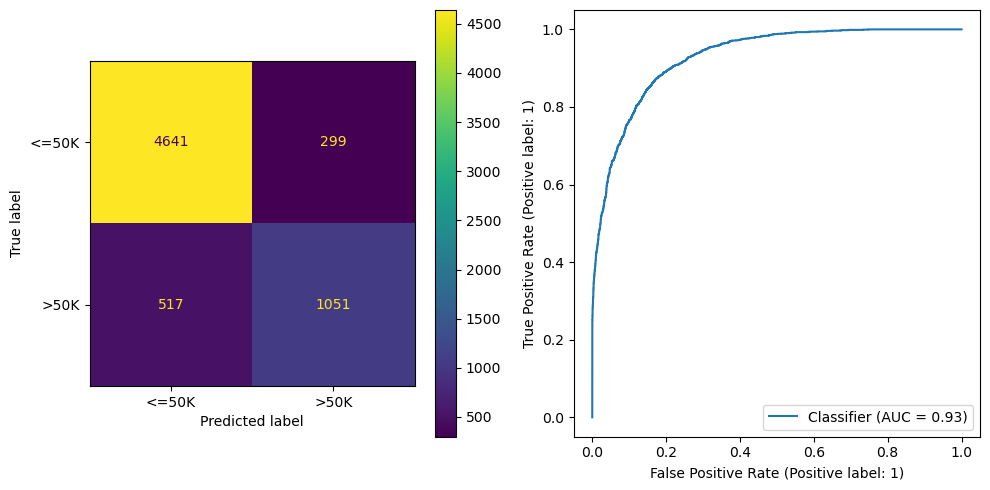

In [16]:
from sklearn.metrics import  f1_score, roc_auc_score, ConfusionMatrixDisplay, RocCurveDisplay

import matplotlib.pyplot as plt
%matplotlib inline

roc_auc = roc_auc_score(y_test, y_pred_proba[:, 1])
print(f'ROC-AUC score: {roc_auc:.3f}')

f1 = f1_score(y_test, y_pred)
print(f'F1 score: {f1:.3f}')

fig, axes = plt.subplots(1, 2, figsize = (10, 5))

ConfusionMatrixDisplay.from_predictions(
    y_test,
    y_pred,
    display_labels = binary_encoder.classes_,
    ax = axes[0]
)

RocCurveDisplay.from_predictions(
    y_test,
    y_pred_proba[:, 1],
    ax = axes[1]
)

plt.tight_layout()
plt.show()

## EDA

### Target feature plots

In [17]:
import seaborn as sns
sns.set_theme(style="darkgrid")

#### Categorical variables - Plots without percentile filtration

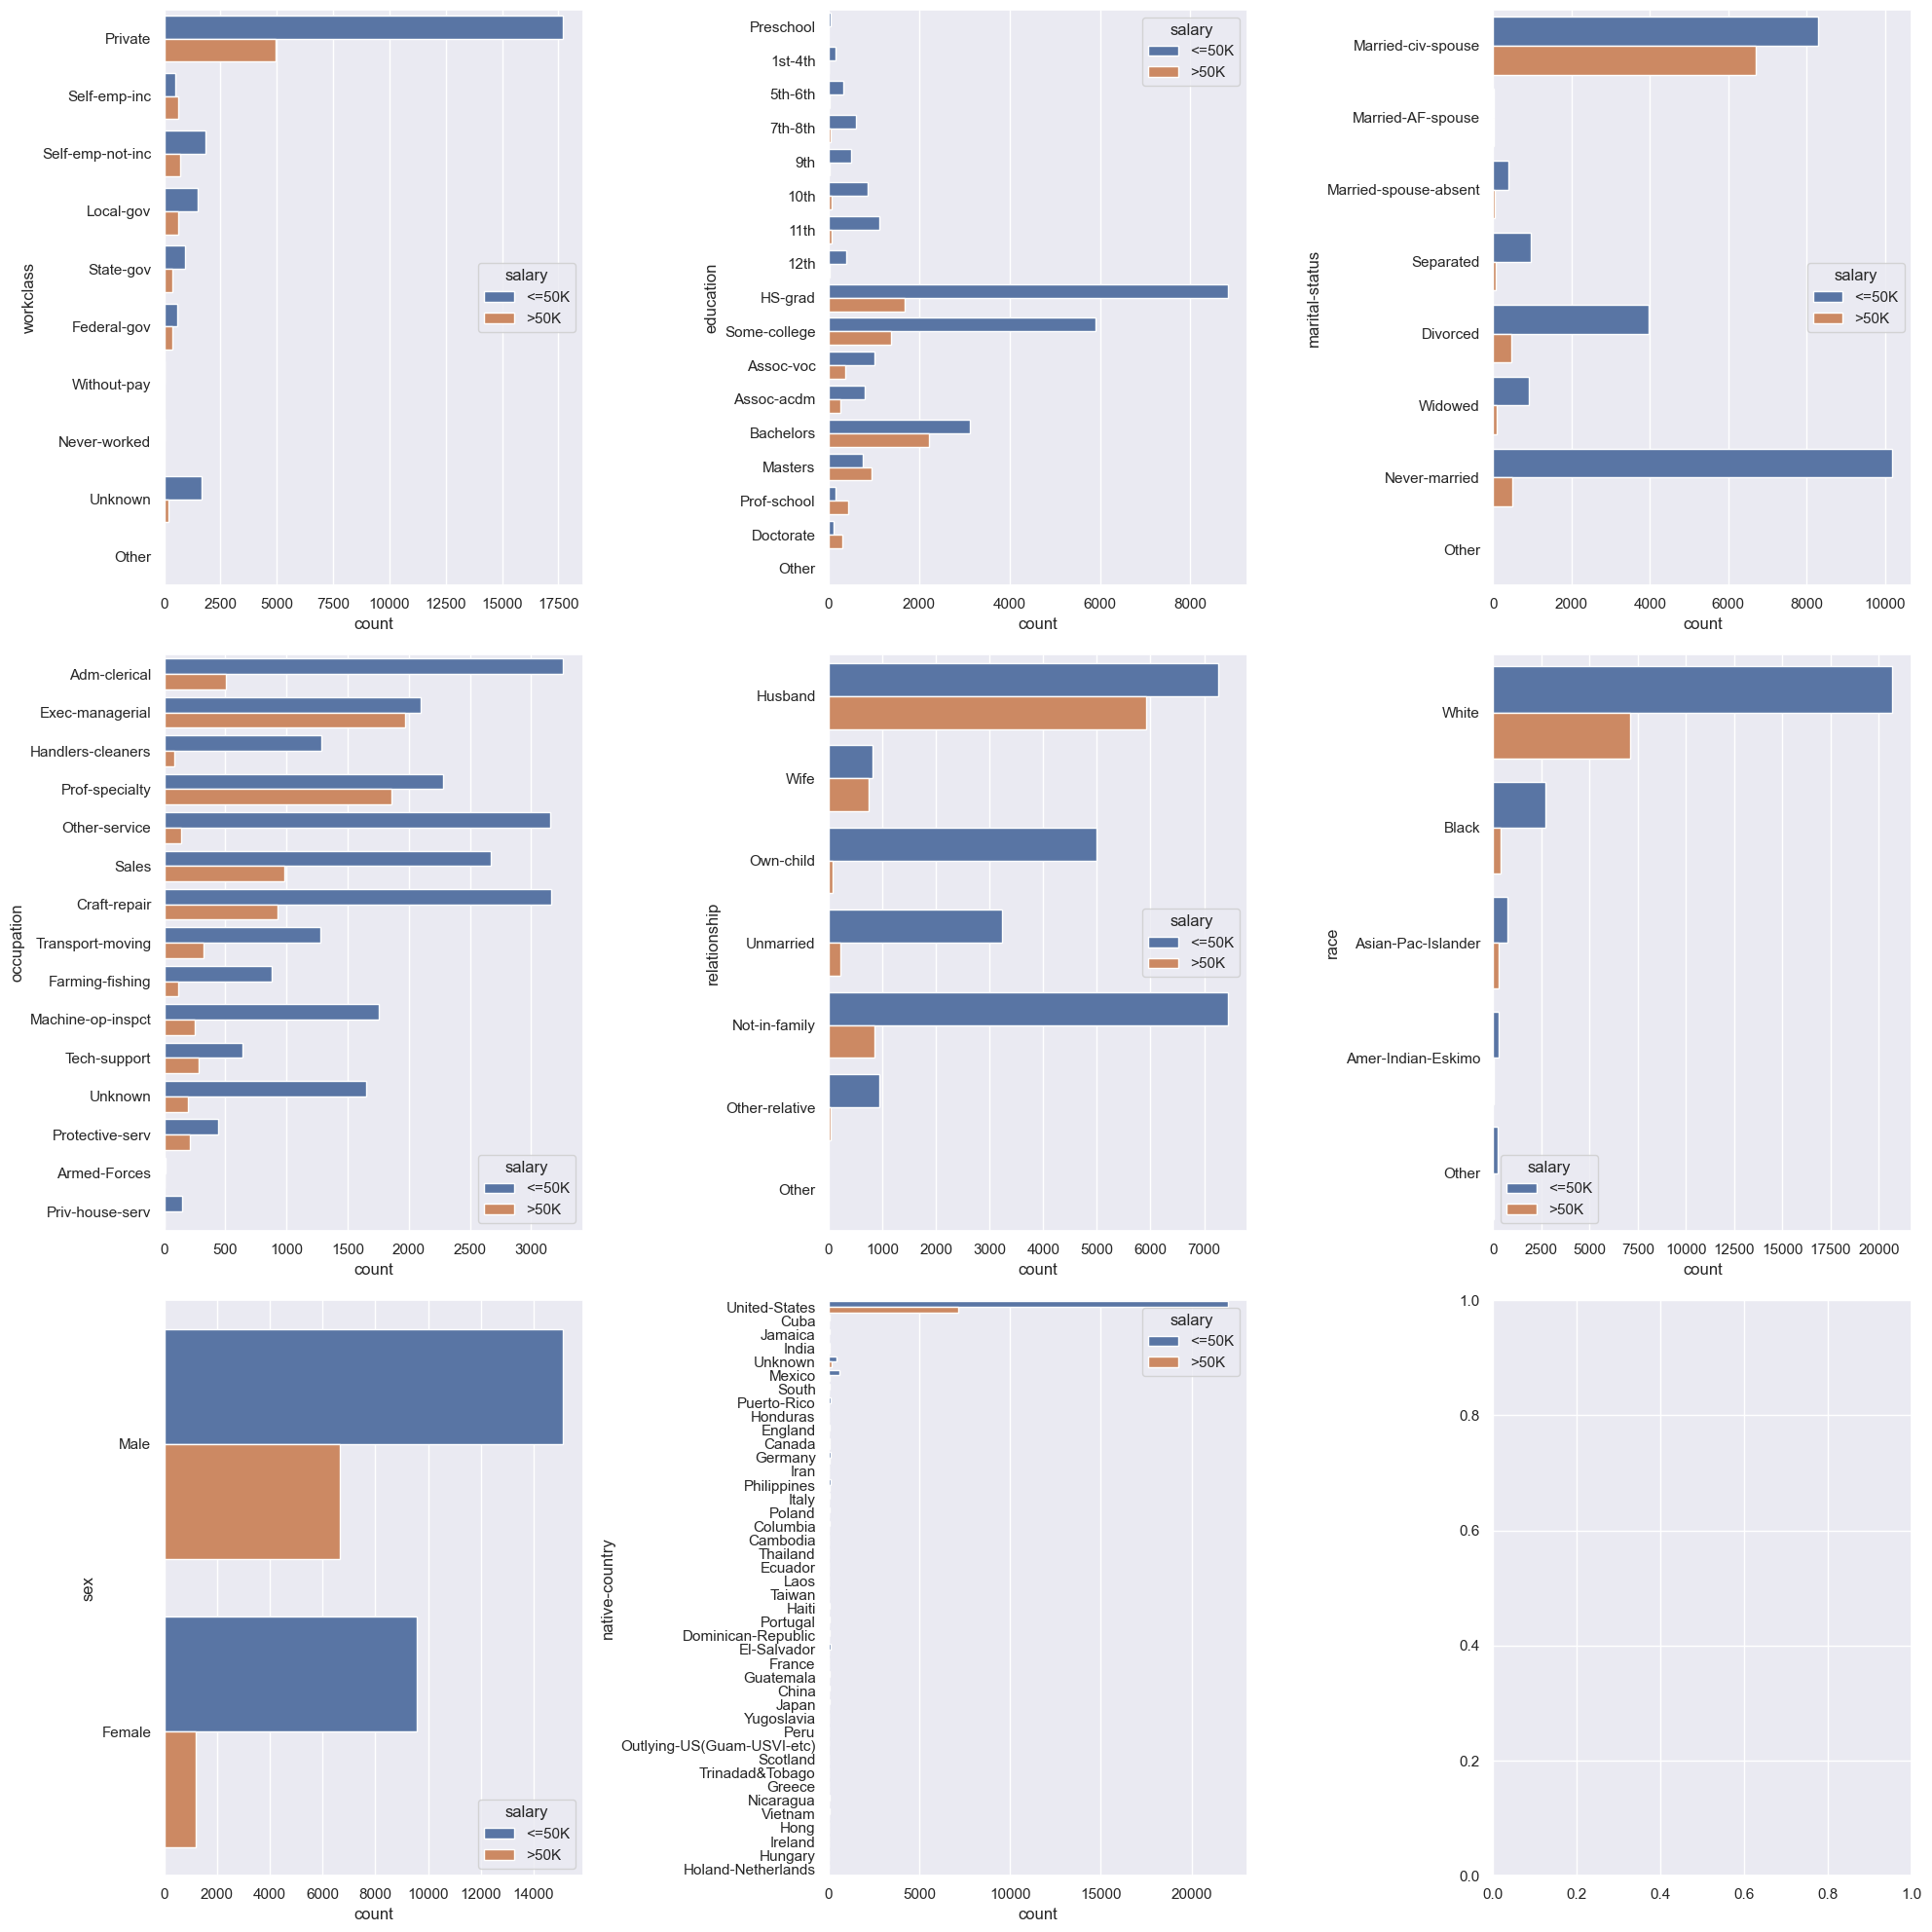

In [18]:
fig, axes = plt.subplots((len(cat_features) + 2) // 3, 3, figsize = (20, 20))

for i, cat_f in enumerate(cat_features):
    ix = i % 3
    iy = i // 3
    sns.countplot(
        data = df,
        y = cat_f,
        hue = target,
        ax = axes[iy, ix],
        order = cat_order[cat_f]
    )

plt.tight_layout()
plt.show()


#### Categorical variables - Plots with percentile filtration

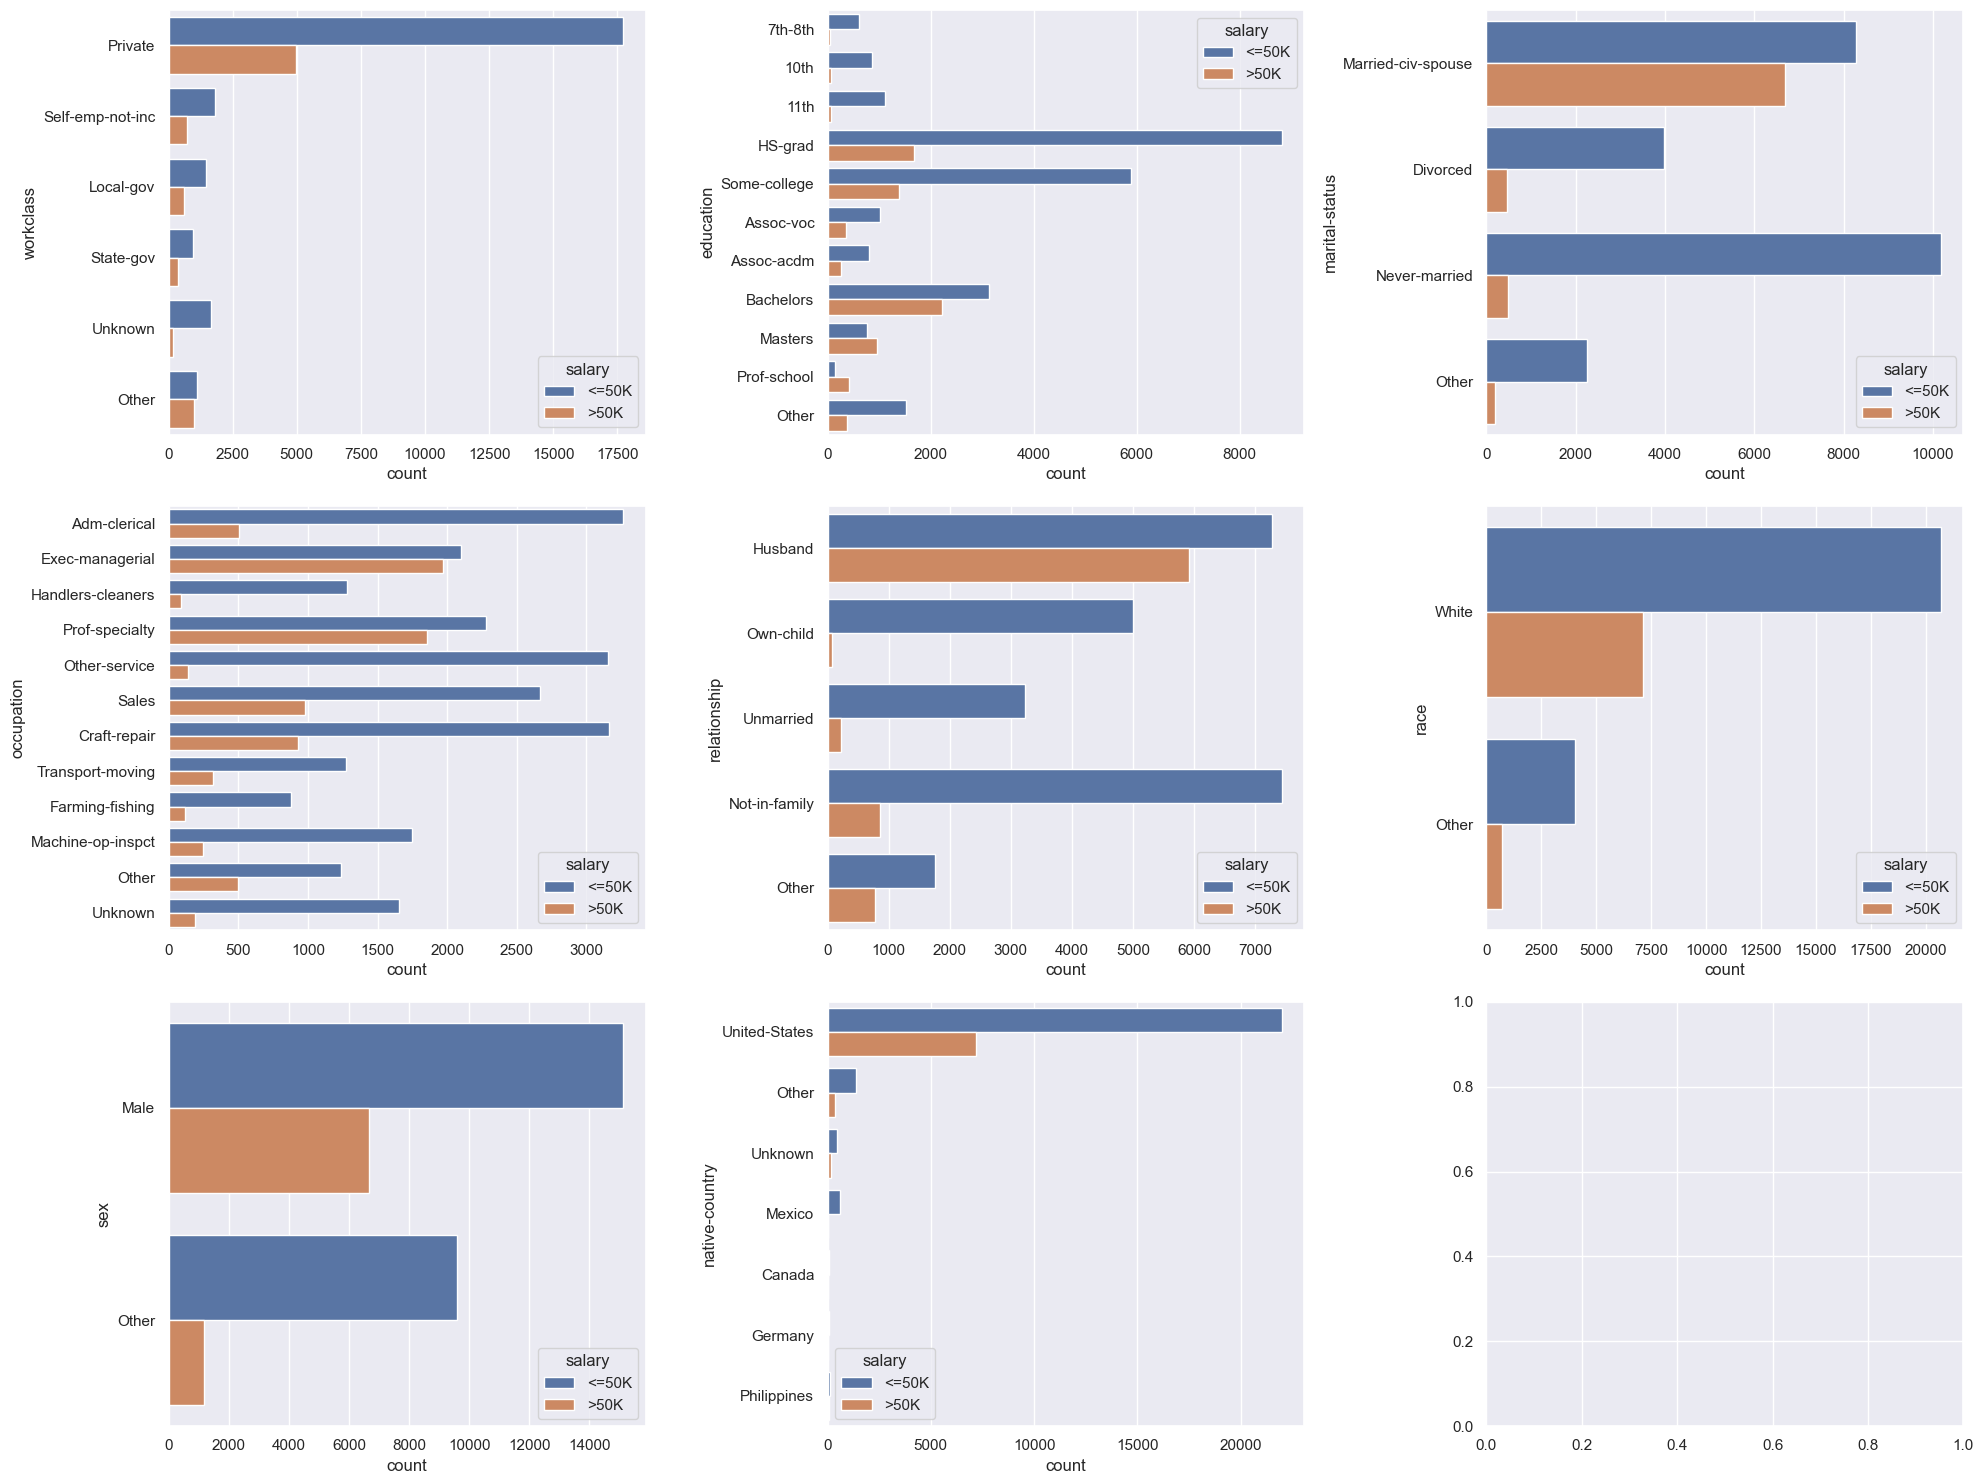

In [19]:
def _transform_get_percentile(df, cat_f, target, percentile = 0.95):
    
    tmp_df = df[[cat_f, target]].copy(deep = True)
    value_counts = tmp_df[cat_f].value_counts()
    within_percentile = value_counts[value_counts.cumsum() <= percentile * tmp_df.shape[0]].index.tolist()
    tmp_df[cat_f] = tmp_df[cat_f].map(lambda x: x if x in within_percentile else 'Other')

    return tmp_df


fig, axes = plt.subplots((len(cat_features) + 2) // 3, 3, figsize = (20, 15))

for i, cat_f in enumerate(cat_features):
    tmp_df = _transform_get_percentile(df, cat_f, target)
    ix = i % 3
    iy = i // 3
    tmp_order = [v for v in cat_order[cat_f] if v in tmp_df[cat_f].unique()] \
                if cat_order[cat_f] is not None else None
    sns.countplot(
        data = tmp_df,
        y = cat_f,
        hue = target,
        ax = axes[iy, ix],
        order = tmp_order
    )

plt.tight_layout()
plt.show()


#### Numeric variables

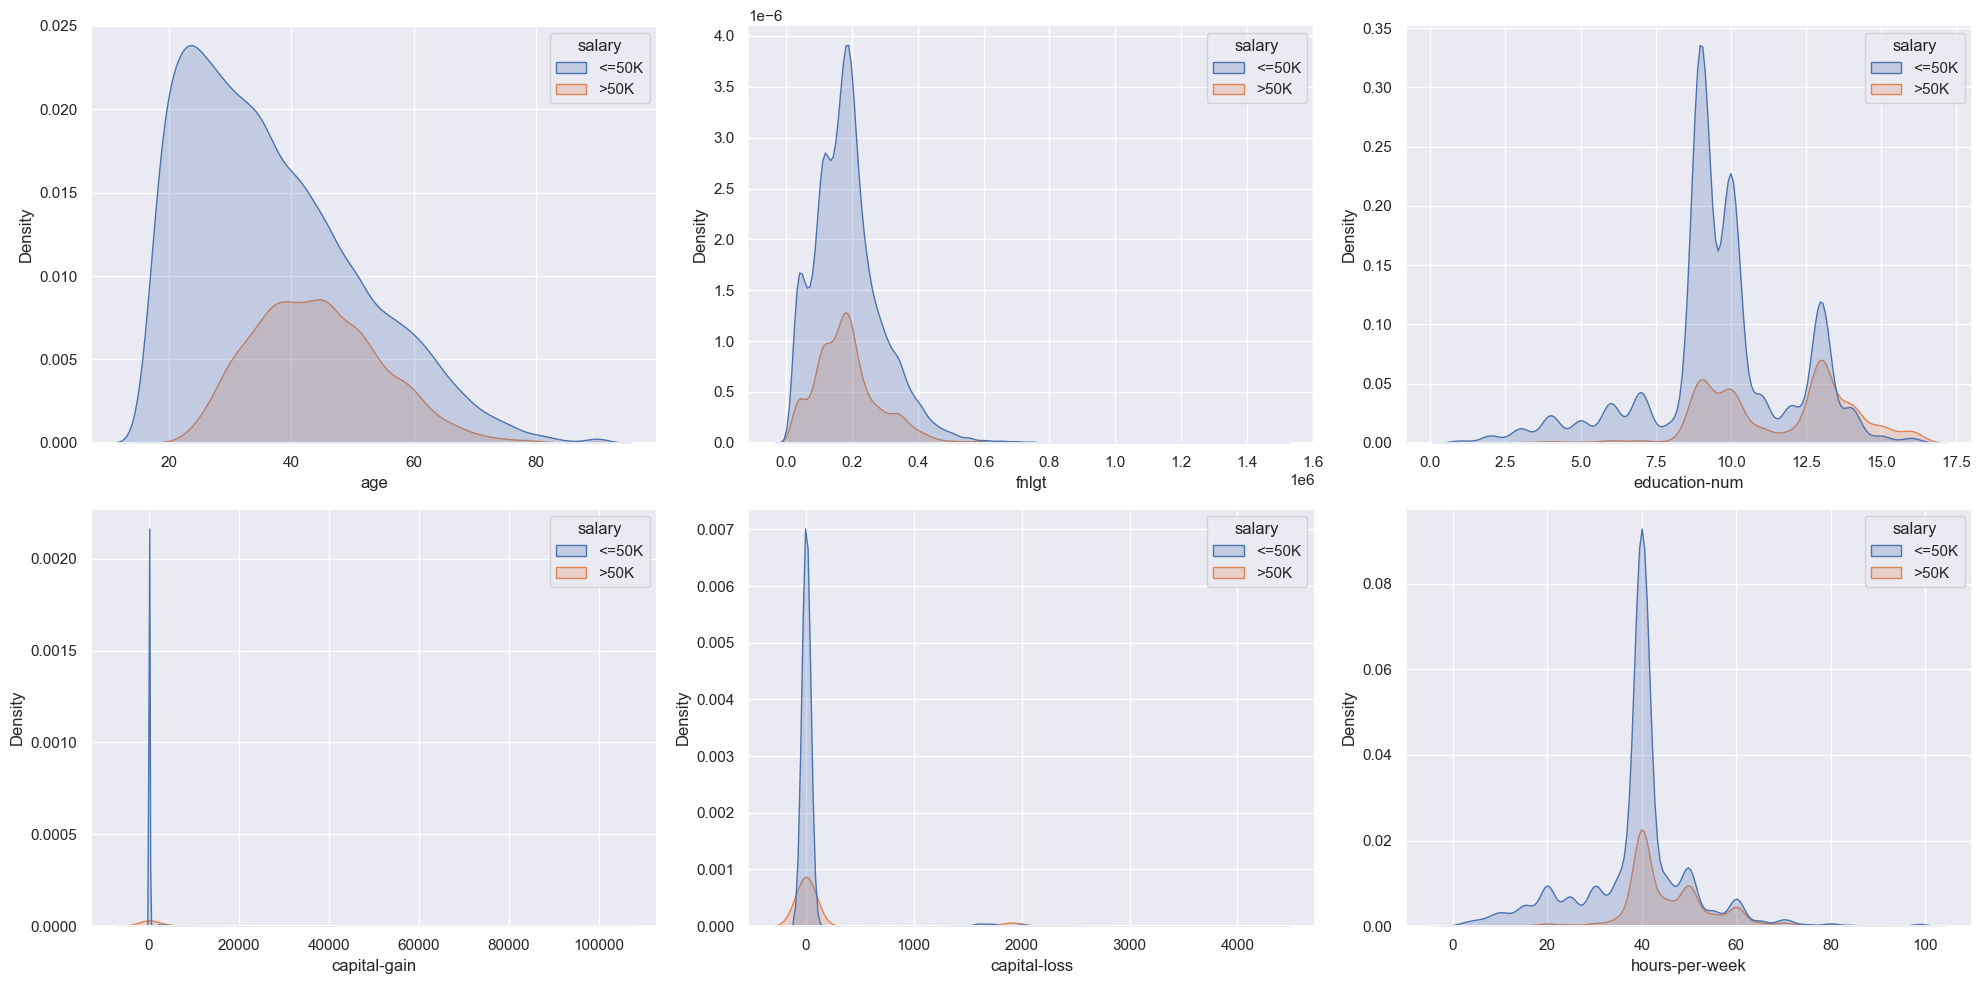

In [20]:
fig, axes = plt.subplots((len(num_features) + 2) // 3, 3, figsize = (20, 10))

for i, num_f in enumerate(num_features):
    ix = i % 3
    iy = i // 3
    sns.kdeplot(
        data = df, 
        x = num_f,
        hue = target,
        ax = axes[iy, ix],
        fill=True
    )


plt.tight_layout()
plt.show()


### Independent variables plots

#### `age`

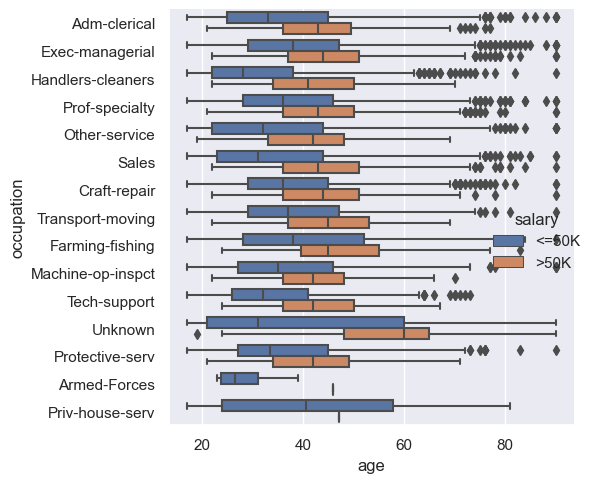

In [20]:
sns.catplot(
    x = 'age',
    y = 'occupation',
    hue = target,
    kind = 'box',
    data = df
)

plt.tight_layout()
plt.show()

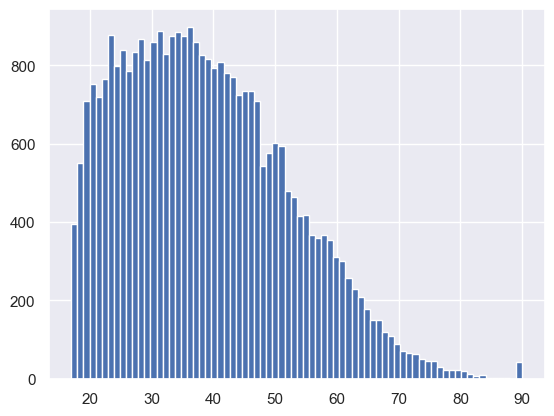

In [21]:
age = df['age']
assert age.between(17, 90).all()
age.hist(bins = 74)
plt.show()

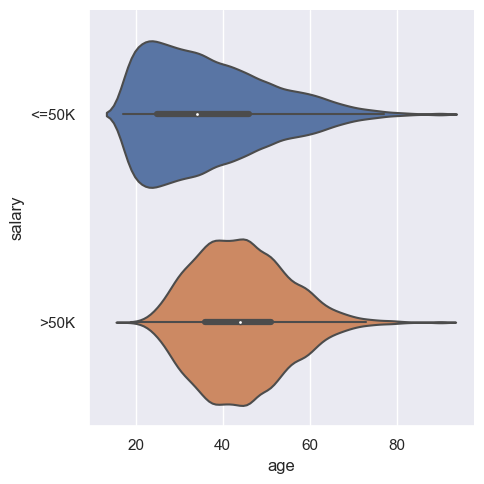

In [22]:
sns.catplot(
    x='age',
    y='salary',
    kind='violin',
    data=df
 )
plt.show()

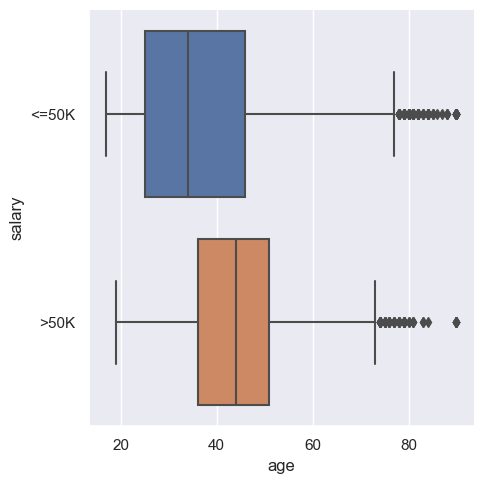

In [23]:
sns.catplot(
    x='age',
    y='salary',
    kind='box',
    data=df
 )
plt.show()

#### `workclass`

In [24]:
workclass = df['workclass']
workclass.value_counts()

Private             22673
Self-emp-not-inc     2540
Local-gov            2093
Unknown              1836
State-gov            1298
Self-emp-inc         1116
Federal-gov           960
Without-pay            14
Never-worked            7
Name: workclass, dtype: int64

#### `fnlgt`

In [25]:
fnlgt = df['fnlgt']
pd.DataFrame(data = {'10 largest': fnlgt.nlargest(10).values, '10 smallest': fnlgt.nsmallest(10).values})

10 largest  10 smallest
0     1484705        12285
1     1455435        13769
2     1366120        14878
3     1268339        18827
4     1226583        19214
5     1184622        19302
6     1161363        19302
7     1125613        19302
8     1097453        19302
9     1085515        19302

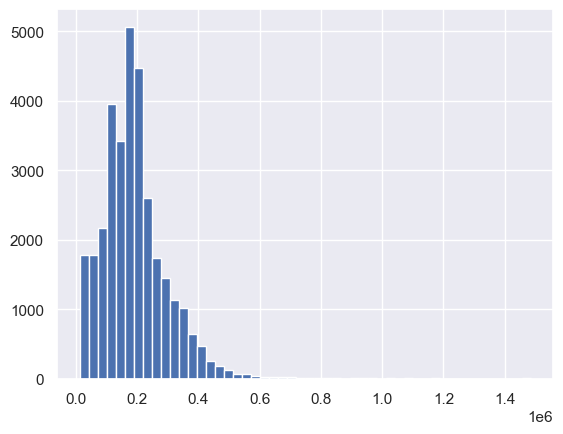

In [26]:
fnlgt.hist(bins = 50)
plt.show()

#### `education`

In [27]:
education = df['education']
education.value_counts()

HS-grad         10494
Some-college     7282
Bachelors        5353
Masters          1722
Assoc-voc        1382
11th             1175
Assoc-acdm       1067
10th              933
7th-8th           645
Prof-school       576
9th               514
12th              433
Doctorate         413
5th-6th           332
1st-4th           166
Preschool          50
Name: education, dtype: int64

#### `education-num`

In [28]:
education_num = df['education-num']
education_num.value_counts()

9     10494
10     7282
13     5353
14     1722
11     1382
7      1175
12     1067
6       933
4       645
15      576
5       514
8       433
16      413
3       332
2       166
1        50
Name: education-num, dtype: int64

#### `marital-status`

In [29]:
marital_status = df['marital-status']
marital_status.value_counts()

Married-civ-spouse       14970
Never-married            10667
Divorced                  4441
Separated                 1025
Widowed                    993
Married-spouse-absent      418
Married-AF-spouse           23
Name: marital-status, dtype: int64

#### `occupation`

In [30]:
occupation = df['occupation']
occupation.value_counts()

Prof-specialty       4136
Craft-repair         4094
Exec-managerial      4065
Adm-clerical         3768
Sales                3650
Other-service        3291
Machine-op-inspct    2000
Unknown              1843
Transport-moving     1597
Handlers-cleaners    1369
Farming-fishing       992
Tech-support          927
Protective-serv       649
Priv-house-serv       147
Armed-Forces            9
Name: occupation, dtype: int64

#### `relationship`

In [31]:
relationship = df['relationship']
relationship.value_counts()

Husband           13187
Not-in-family      8292
Own-child          5064
Unmarried          3445
Wife               1568
Other-relative      981
Name: relationship, dtype: int64

#### `race`

In [32]:
race = df['race']
race.value_counts()

White                 27795
Black                  3122
Asian-Pac-Islander     1038
Amer-Indian-Eskimo      311
Other                   271
Name: race, dtype: int64

#### `sex`

In [33]:
sex = df['sex']
sex.value_counts()

Male      21775
Female    10762
Name: sex, dtype: int64

#### `capital-gain`

In [34]:
capital_gain = df['capital-gain']
pd.DataFrame(data = {'10 largest': capital_gain.nlargest(10).values, '10 smallest': capital_gain.nsmallest(10).values})

10 largest  10 smallest
0       99999            0
1       99999            0
2       99999            0
3       99999            0
4       99999            0
5       99999            0
6       99999            0
7       99999            0
8       99999            0
9       99999            0

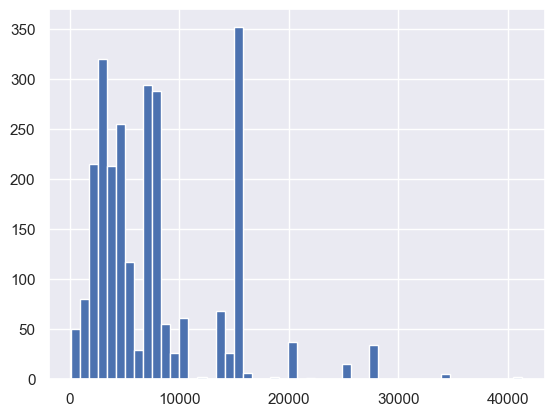

In [35]:
capital_gain[(capital_gain != 0) & (capital_gain != 99999)].hist(bins = 50)
plt.show()

#### `capital-loss`

In [36]:
capital_loss = df['capital-loss']
pd.DataFrame(data = {'10 largest': capital_loss.nlargest(10).values, '10 smallest': capital_loss.nsmallest(10).values})

10 largest  10 smallest
0        4356            0
1        4356            0
2        4356            0
3        3900            0
4        3900            0
5        3770            0
6        3770            0
7        3683            0
8        3683            0
9        3004            0

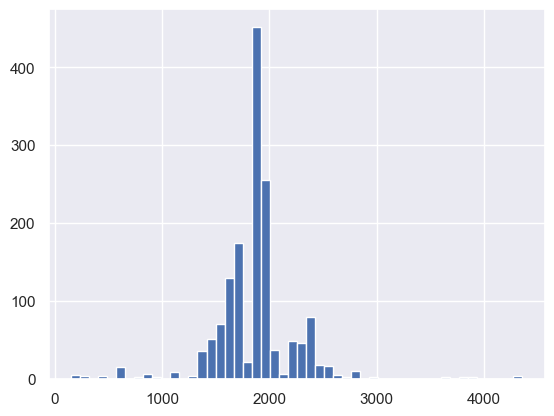

In [37]:
capital_loss[capital_loss != 0].hist(bins = 50)
plt.show()

#### `hours-per-week`

In [38]:
hours_per_week = df['hours-per-week']
pd.DataFrame(data = {'10 largest': hours_per_week.nlargest(10).values, '10 smallest': hours_per_week.nsmallest(10).values})

10 largest  10 smallest
0          99            1
1          99            1
2          99            1
3          99            1
4          99            1
5          99            1
6          99            1
7          99            1
8          99            1
9          99            1

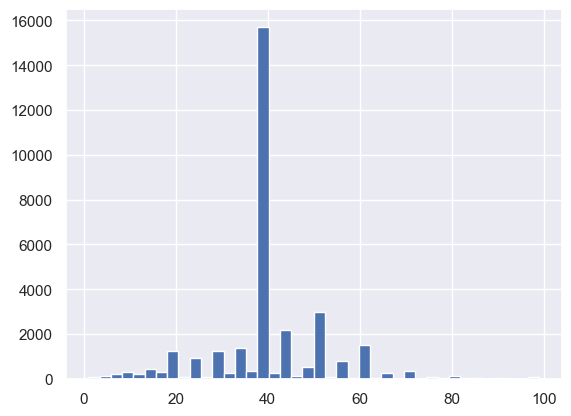

In [39]:
hours_per_week.hist(bins = 40)
plt.show()

#### `native-country`

In [40]:
native_country = df['native-country']
native_country.value_counts()

United-States                 29153
Mexico                          639
Unknown                         582
Philippines                     198
Germany                         137
Canada                          121
Puerto-Rico                     114
El-Salvador                     106
India                           100
Cuba                             95
England                          90
Jamaica                          81
South                            80
China                            75
Italy                            73
Dominican-Republic               70
Vietnam                          67
Japan                            62
Guatemala                        62
Poland                           60
Columbia                         59
Taiwan                           51
Haiti                            44
Iran                             43
Portugal                         37
Nicaragua                        34
Peru                             31
France                      

## Model bias

### Preprocessing

In [209]:
df_aq = X_test.copy(deep = True)

In [210]:
df_aq['label_value'] = y_test
df_aq['score'] = y_pred
df_aq.head()

age  workclass   fnlgt     education  education-num  \
1719    38    Private  187069       HS-grad              9   
3714    32    Private  353994     Bachelors             13   
22912   23  Local-gov  197918  Some-college             10   
16430   57  State-gov  254949       HS-grad              9   
26363   48    Unknown  353824  Some-college             10   

           marital-status        occupation    relationship  \
1719   Married-civ-spouse  Transport-moving         Husband   
3714   Married-civ-spouse   Exec-managerial  Other-relative   
22912       Never-married   Protective-serv       Own-child   
16430  Married-civ-spouse   Exec-managerial         Husband   
26363  Married-civ-spouse           Unknown         Husband   

                     race     sex  capital-gain  capital-loss  hours-per-week  \
1719                White    Male             0             0              45   
3714   Asian-Pac-Islander  Female             0             0              40   
22912               White    Male             0             0              40   
16430               White    Male             0             0              40   
26363               White    Male             0             0              40   

      native-country  label_value  score  
1719   United-States            0      0  
3714           China            1      0  
22912  United-States            1      0  
16430  United-States            1      0  
26363        Unknown            1      0

In [211]:
qcut_cols = [n for n in num_features if n not in ['fnlgt', 'education-num', 'capital-gain', 'capital-loss']]
for num_f in qcut_cols:
    df_aq[num_f + '-qcut'] = pd.qcut(df_aq[num_f], 10, duplicates = 'drop').astype(str)
aq_cols = cat_features + [n + '-qcut' for n in qcut_cols] + ['label_value', 'score']
df_aq = df_aq.loc[:, aq_cols]
df_aq.head()

workclass     education      marital-status        occupation  \
1719     Private       HS-grad  Married-civ-spouse  Transport-moving   
3714     Private     Bachelors  Married-civ-spouse   Exec-managerial   
22912  Local-gov  Some-college       Never-married   Protective-serv   
16430  State-gov       HS-grad  Married-civ-spouse   Exec-managerial   
26363    Unknown  Some-college  Married-civ-spouse           Unknown   

         relationship                race     sex native-country  \
1719          Husband               White    Male  United-States   
3714   Other-relative  Asian-Pac-Islander  Female          China   
22912       Own-child               White    Male  United-States   
16430         Husband               White    Male  United-States   
26363         Husband               White    Male        Unknown   

           age-qcut hours-per-week-qcut  label_value  score  
1719   (37.0, 41.0]        (40.0, 50.0]            0      0  
3714   (30.0, 33.0]        (35.0, 40.0]            1      0  
22912  (22.0, 26.0]        (35.0, 40.0]            1      0  
16430  (51.0, 58.0]        (35.0, 40.0]            1      0  
26363  (45.0, 51.0]        (35.0, 40.0]            1      0

In [212]:
# merge small group frequencies
def _transform_get_percentile(df, cat_f, target, percentile = 0.95):
    
    tmp_df = df[[cat_f, target]].copy(deep = True)
    value_counts = tmp_df[cat_f].value_counts()
    within_percentile = value_counts[value_counts.cumsum() <= percentile * tmp_df.shape[0]].index.tolist()
    tmp_df[cat_f] = tmp_df[cat_f].map(lambda x: x if x in within_percentile else 'Other')

    return tmp_df

for cat_f in cat_features:
    df_aq[cat_f] = _transform_get_percentile(df, cat_f, target)[cat_f]

### Biases across subgroups

In [214]:
from aequitas.group import Group
from aequitas.bias import Bias 
from aequitas.fairness import Fairness
from aequitas.plotting import Plot

aqp = Plot()

In [215]:
group = Group()
xtab, idxs = group.get_crosstabs(df_aq)
absolute_metrics = group.list_absolute_metrics(xtab)

# xtab[[col for col in xtab.columns if col not in absolute_metrics + ['model_id', 'score_threshold', 'k', 'pp', 'pn', 'group_label_pos', 'group_label_neg']]]
group_size_fr = xtab['group_size'] / xtab['total_entities']
xtab.loc[group_size_fr >= 0.05, ['attribute_name', 'attribute_value', 'tp', 'fp', 'tn', 'fn', 'tpr', 'tnr', 'precision', 'npv', 'group_size', 'total_entities']].round(2)

attribute_name     attribute_value   tp   fp    tn   fn   tpr   tnr  \
0             workclass           Local-gov  101   32   265   32  0.76  0.89   
1             workclass               Other  152   51   157   37  0.80  0.75   
2             workclass             Private  648  170  3366  340  0.66  0.95   
3             workclass    Self-emp-not-inc   79   29   347   64  0.55  0.92   
5             workclass             Unknown   15    7   325   15  0.50  0.98   
11            education           Bachelors  361  124   499   69  0.84  0.80   
12            education             HS-grad  119   40  1683  217  0.35  0.98   
13            education             Masters  169   37   112   19  0.90  0.75   
14            education               Other   52   12   281   19  0.73  0.96   
16            education        Some-college  163   49  1155  116  0.58  0.96   
17       marital-status            Divorced   36    7   766   42  0.46  0.99   
18       marital-status  Married-civ-spouse  961  278  1447  397  0.71  0.84   
19       marital-status       Never-married   40   11  1980   64  0.38  0.99   
20       marital-status               Other   14    3   448   14  0.50  0.99   
21           occupation        Adm-clerical   56   15   636   47  0.54  0.98   
22           occupation        Craft-repair   69   14   611  109  0.39  0.98   
23           occupation     Exec-managerial  318   80   331   71  0.82  0.81   
26           occupation   Machine-op-inspct   16    2   373   28  0.36  0.99   
27           occupation               Other   79   35   223   29  0.73  0.86   
28           occupation       Other-service    7    0   640   23  0.23  1.00   
29           occupation      Prof-specialty  319   80   374   63  0.84  0.82   
30           occupation               Sales  141   62   482   53  0.73  0.89   
31           occupation    Transport-moving   16    4   255   58  0.22  0.98   
32           occupation             Unknown   15    7   326   15  0.50  0.98   
33         relationship             Husband  844  242  1265  342  0.71  0.84   
34         relationship       Not-in-family   66   15  1394   78  0.46  0.99   
35         relationship               Other  117   33   319   54  0.68  0.91   
36         relationship           Own-child    7    4  1021   15  0.32  1.00   
37         relationship           Unmarried   17    5   642   28  0.38  0.99   
38                 race               Other   91   26   739   69  0.57  0.97   
39                 race               White  960  273  3902  448  0.68  0.93   
40                  sex                Male  910  266  2795  414  0.69  0.91   
41                  sex               Other  141   33  1846  103  0.58  0.98   
45       native-country               Other   51   12   248   23  0.69  0.95   
47       native-country       United-States  955  271  4099  473  0.67  0.94   
49             age-qcut      (16.999, 22.0]    1    1   763    3  0.25  1.00   
50             age-qcut        (22.0, 26.0]    9    2   639   18  0.33  1.00   
51             age-qcut        (26.0, 30.0]   46   15   533   60  0.43  0.97   
52             age-qcut        (30.0, 33.0]   65   34   394   45  0.59  0.92   
53             age-qcut        (33.0, 37.0]  138   34   447   75  0.65  0.93   
54             age-qcut        (37.0, 41.0]  175   44   406   47  0.79  0.90   
55             age-qcut        (41.0, 45.0]  149   50   330   51  0.74  0.87   
56             age-qcut        (45.0, 51.0]  216   54   399   85  0.72  0.88   
57             age-qcut        (51.0, 58.0]  154   40   332   72  0.68  0.89   
58             age-qcut        (58.0, 90.0]   98   25   398   61  0.62  0.94   
59  hours-per-week-qcut       (0.999, 25.0]   24    7   734   23  0.51  0.99   
60  hours-per-week-qcut        (25.0, 35.0]   32   11   495   29  0.52  0.98   
61  hours-per-week-qcut        (35.0, 40.0]  423  120  2419  273  0.61  0.95   
62  hours-per-week-qcut        (40.0, 50.0]  342   97   615  117  0.75  0.86   
64  hours

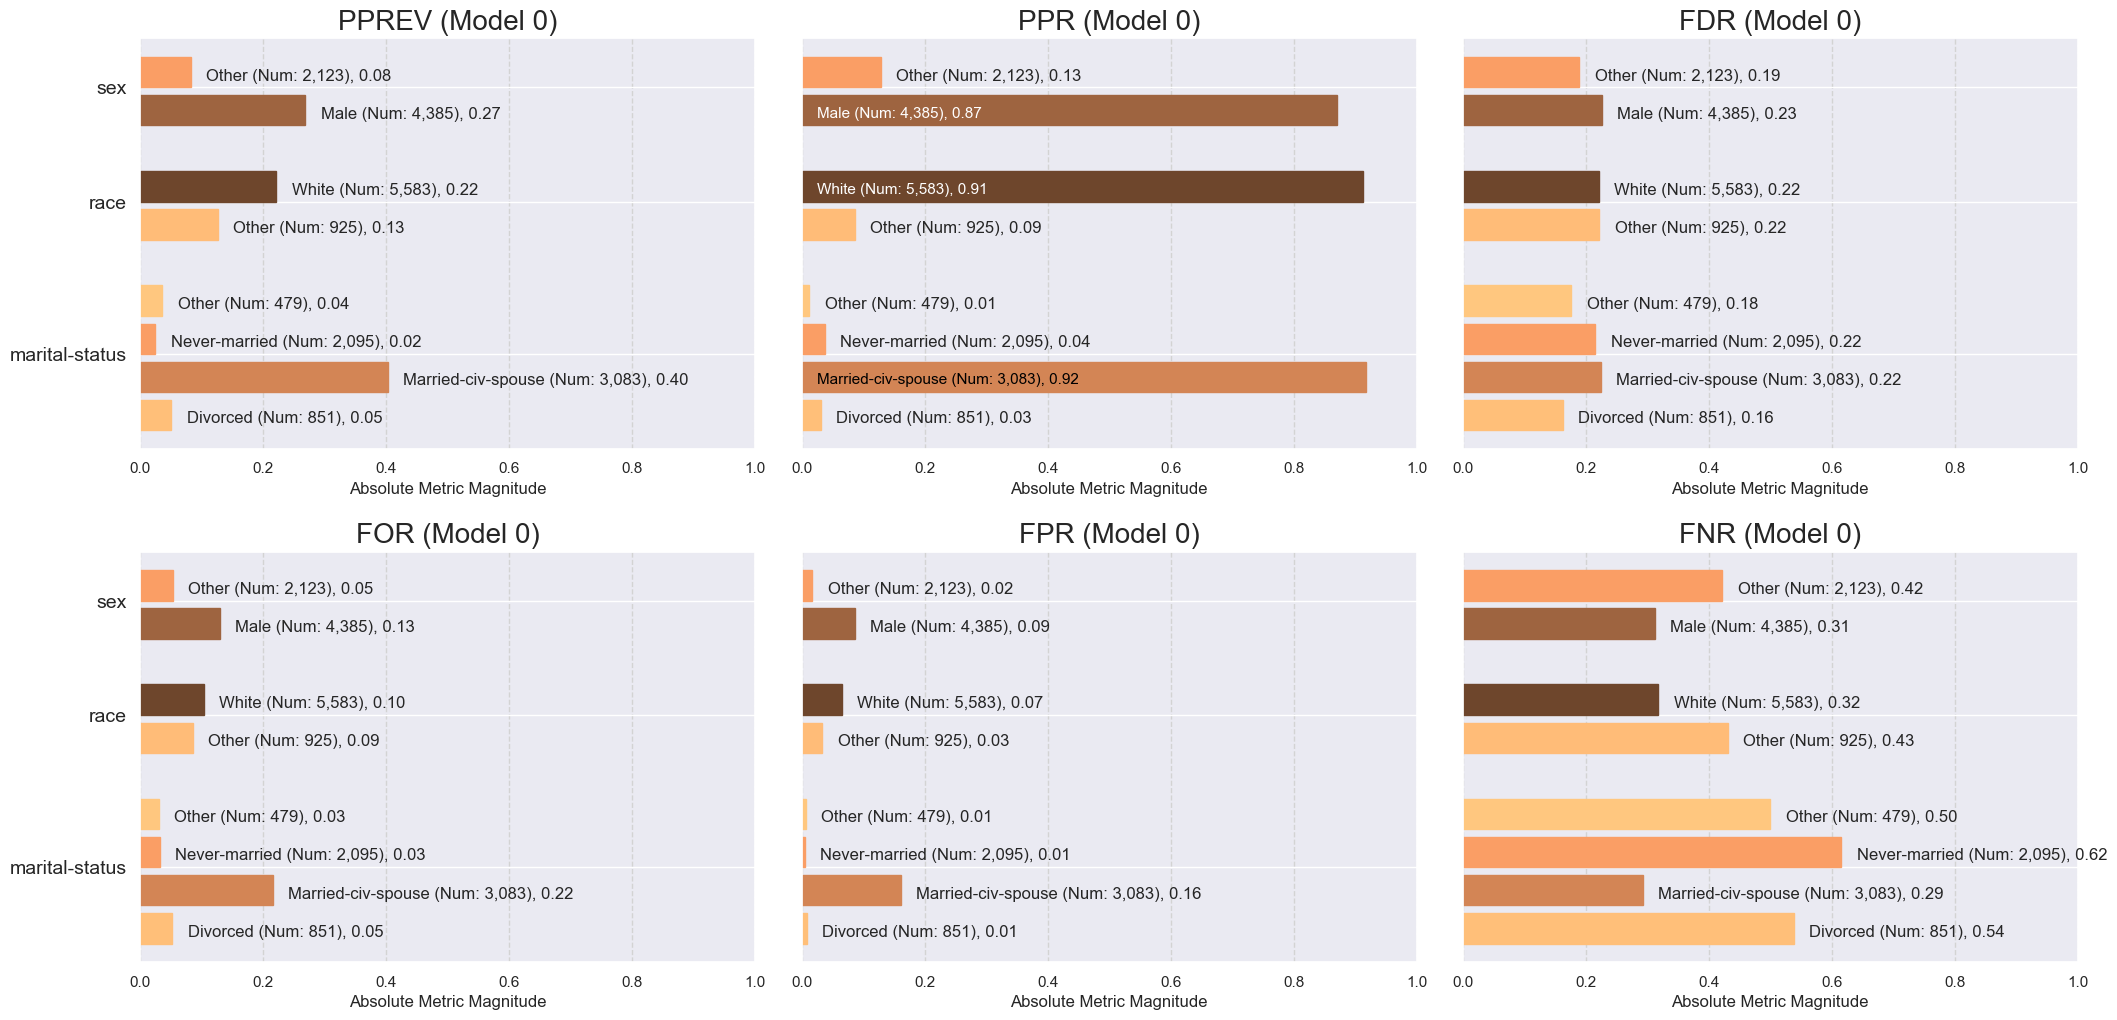

<Figure size 640x480 with 0 Axes>

In [216]:
fnr = aqp.plot_group_metric_all(xtab[(group_size_fr >= 0.01) & xtab['attribute_name'].isin(['marital-status', 'race', 'sex'])], ncols = 3)

### Disparsity levels across groups w.r.t. majority group

In [218]:
# define major groups
ref_group = {}
for c in cat_features + [n + '-qcut' for n in qcut_cols]:
    ref_group[c] = df_aq[c].value_counts().index[0]

bias = Bias()
bias_df = bias.get_disparity_predefined_groups(
    xtab, original_df = df_aq,
    ref_groups_dict = ref_group,
    alpha = 0.05, check_significance = True, mask_significance=True)

get_disparity_predefined_group()


/home/biddy/miniconda3/envs/udacity-mldevops-3rd-project/lib/python3.8/site-packages/scipy/stats/_morestats.py:2643: RuntimeWarning: invalid value encountered in double_scalars
  W = numer / denom
/home/biddy/miniconda3/envs/udacity-mldevops-3rd-project/lib/python3.8/site-packages/scipy/stats/_morestats.py:2643: RuntimeWarning: invalid value encountered in double_scalars
  W = numer / denom
/home/biddy/miniconda3/envs/udacity-mldevops-3rd-project/lib/python3.8/site-packages/scipy/stats/_morestats.py:2643: RuntimeWarning: invalid value encountered in double_scalars
  W = numer / denom
/home/biddy/miniconda3/envs/udacity-mldevops-3rd-project/lib/python3.8/site-packages/scipy/stats/_morestats.py:2643: RuntimeWarning: invalid value encountered in double_scalars
  W = numer / denom
/home/biddy/miniconda3/envs/udacity-mldevops-3rd-project/lib/python3.8/site-packages/scipy/stats/_stats_py.py:1250: RuntimeWarning: divide by zero encountered in divide
  var *= np.divide(n, n-ddof)  # to avoid e

In [219]:
metric = 'npv'
bias_df.loc[
    (bias_df[metric + '_significance'] == True) & bias_df['attribute_name'].isin(['marital-status', 'race', 'sex', 'native-country']), 
    ['attribute_name', 'attribute_value', 'group_size', 'label_value_significance', 'score_significance', metric + '_disparity', metric + '_significance', metric + '_ref_group_value']
]

attribute_name attribute_value  group_size  label_value_significance  \
17  marital-status        Divorced         851                      True   
19  marital-status   Never-married        2095                      True   
20  marital-status           Other         479                     False   
38            race           Other         925                     False   
41             sex           Other        2123                     False   
44  native-country          Mexico         136                      True   
45  native-country           Other         334                     False   

    score_significance  npv_disparity  npv_significance npv_ref_group_value  
17                True       1.208119              True  Married-civ-spouse  
19                True       1.234459              True  Married-civ-spouse  
20                True       1.235744              True  Married-civ-spouse  
38                True       1.019612              True               White  
41                True       1.087446              True                Male  
44                True       1.082345              True       United-States  
45                True       1.020730              True       United-States

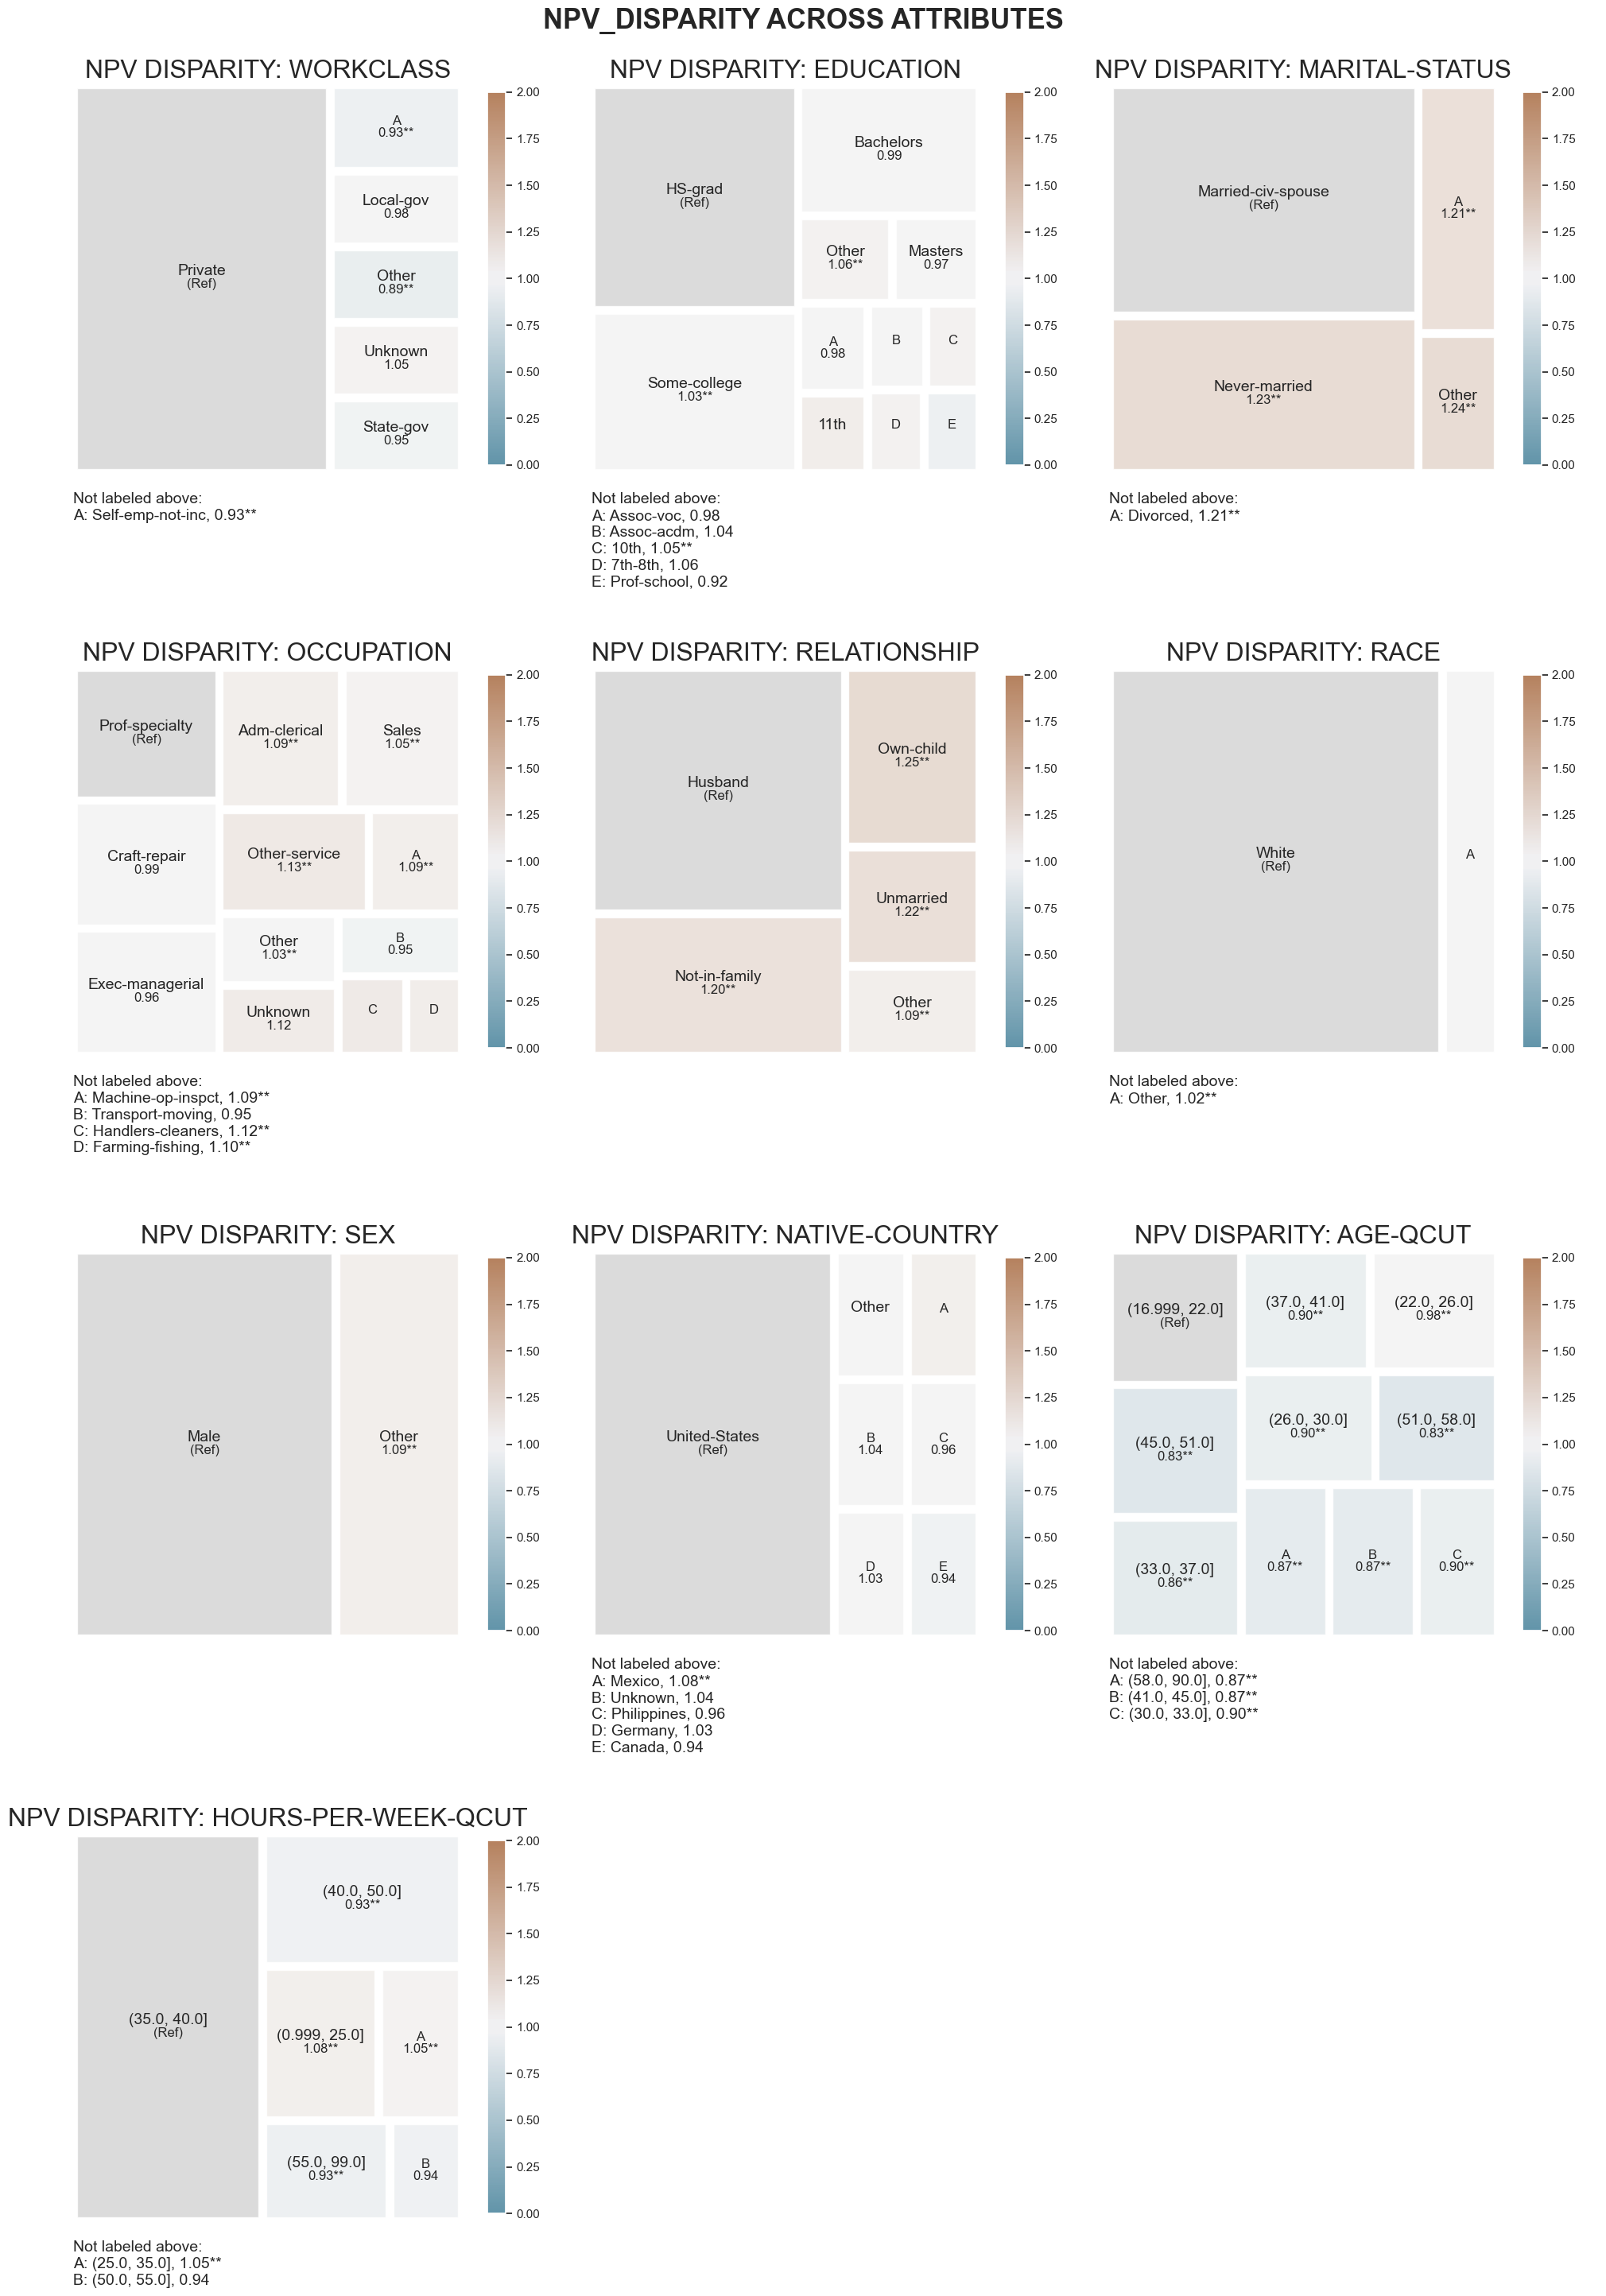

In [220]:
_ = aqp.plot_disparity_all(bias_df, metrics = [metric + '_disparity'], significance_alpha=0.05)

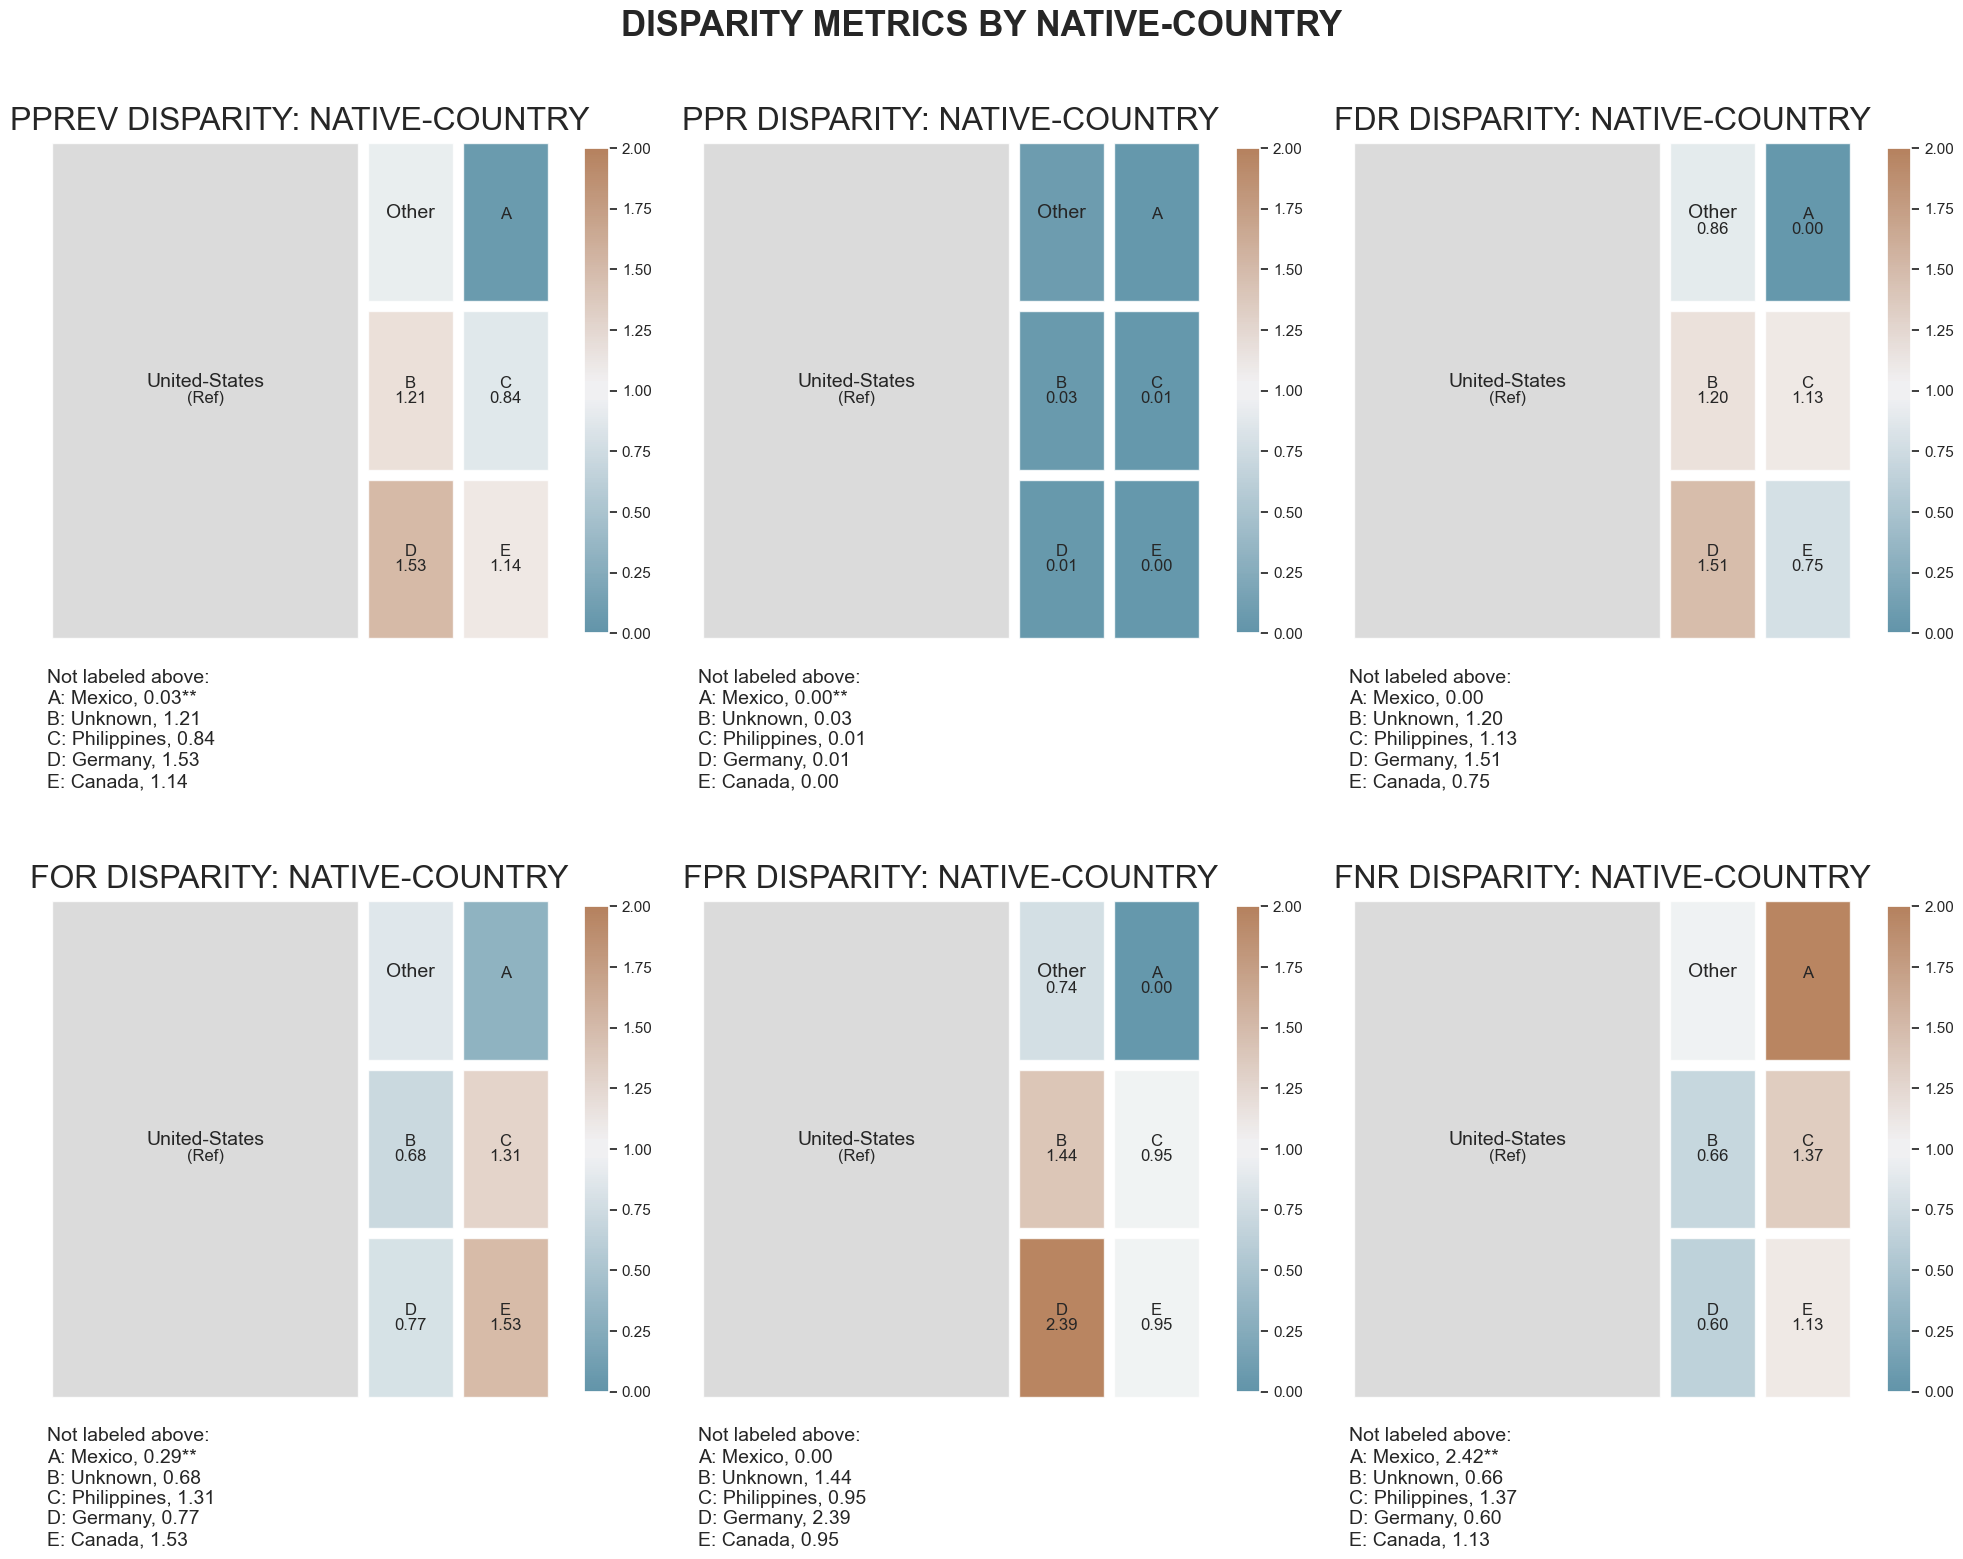

In [221]:
_ = aqp.plot_disparity_all(bias_df, attributes = ['native-country'], significance_alpha=0.05)

In [223]:
fairness = Fairness()
fairness_df = fairness.get_group_value_fairness(bias_df)

gof = fairness.get_overall_fairness(fairness_df)
gof

{'Unsupervised Fairness': False,
 'Supervised Fairness': False,
 'Overall Fairness': False}

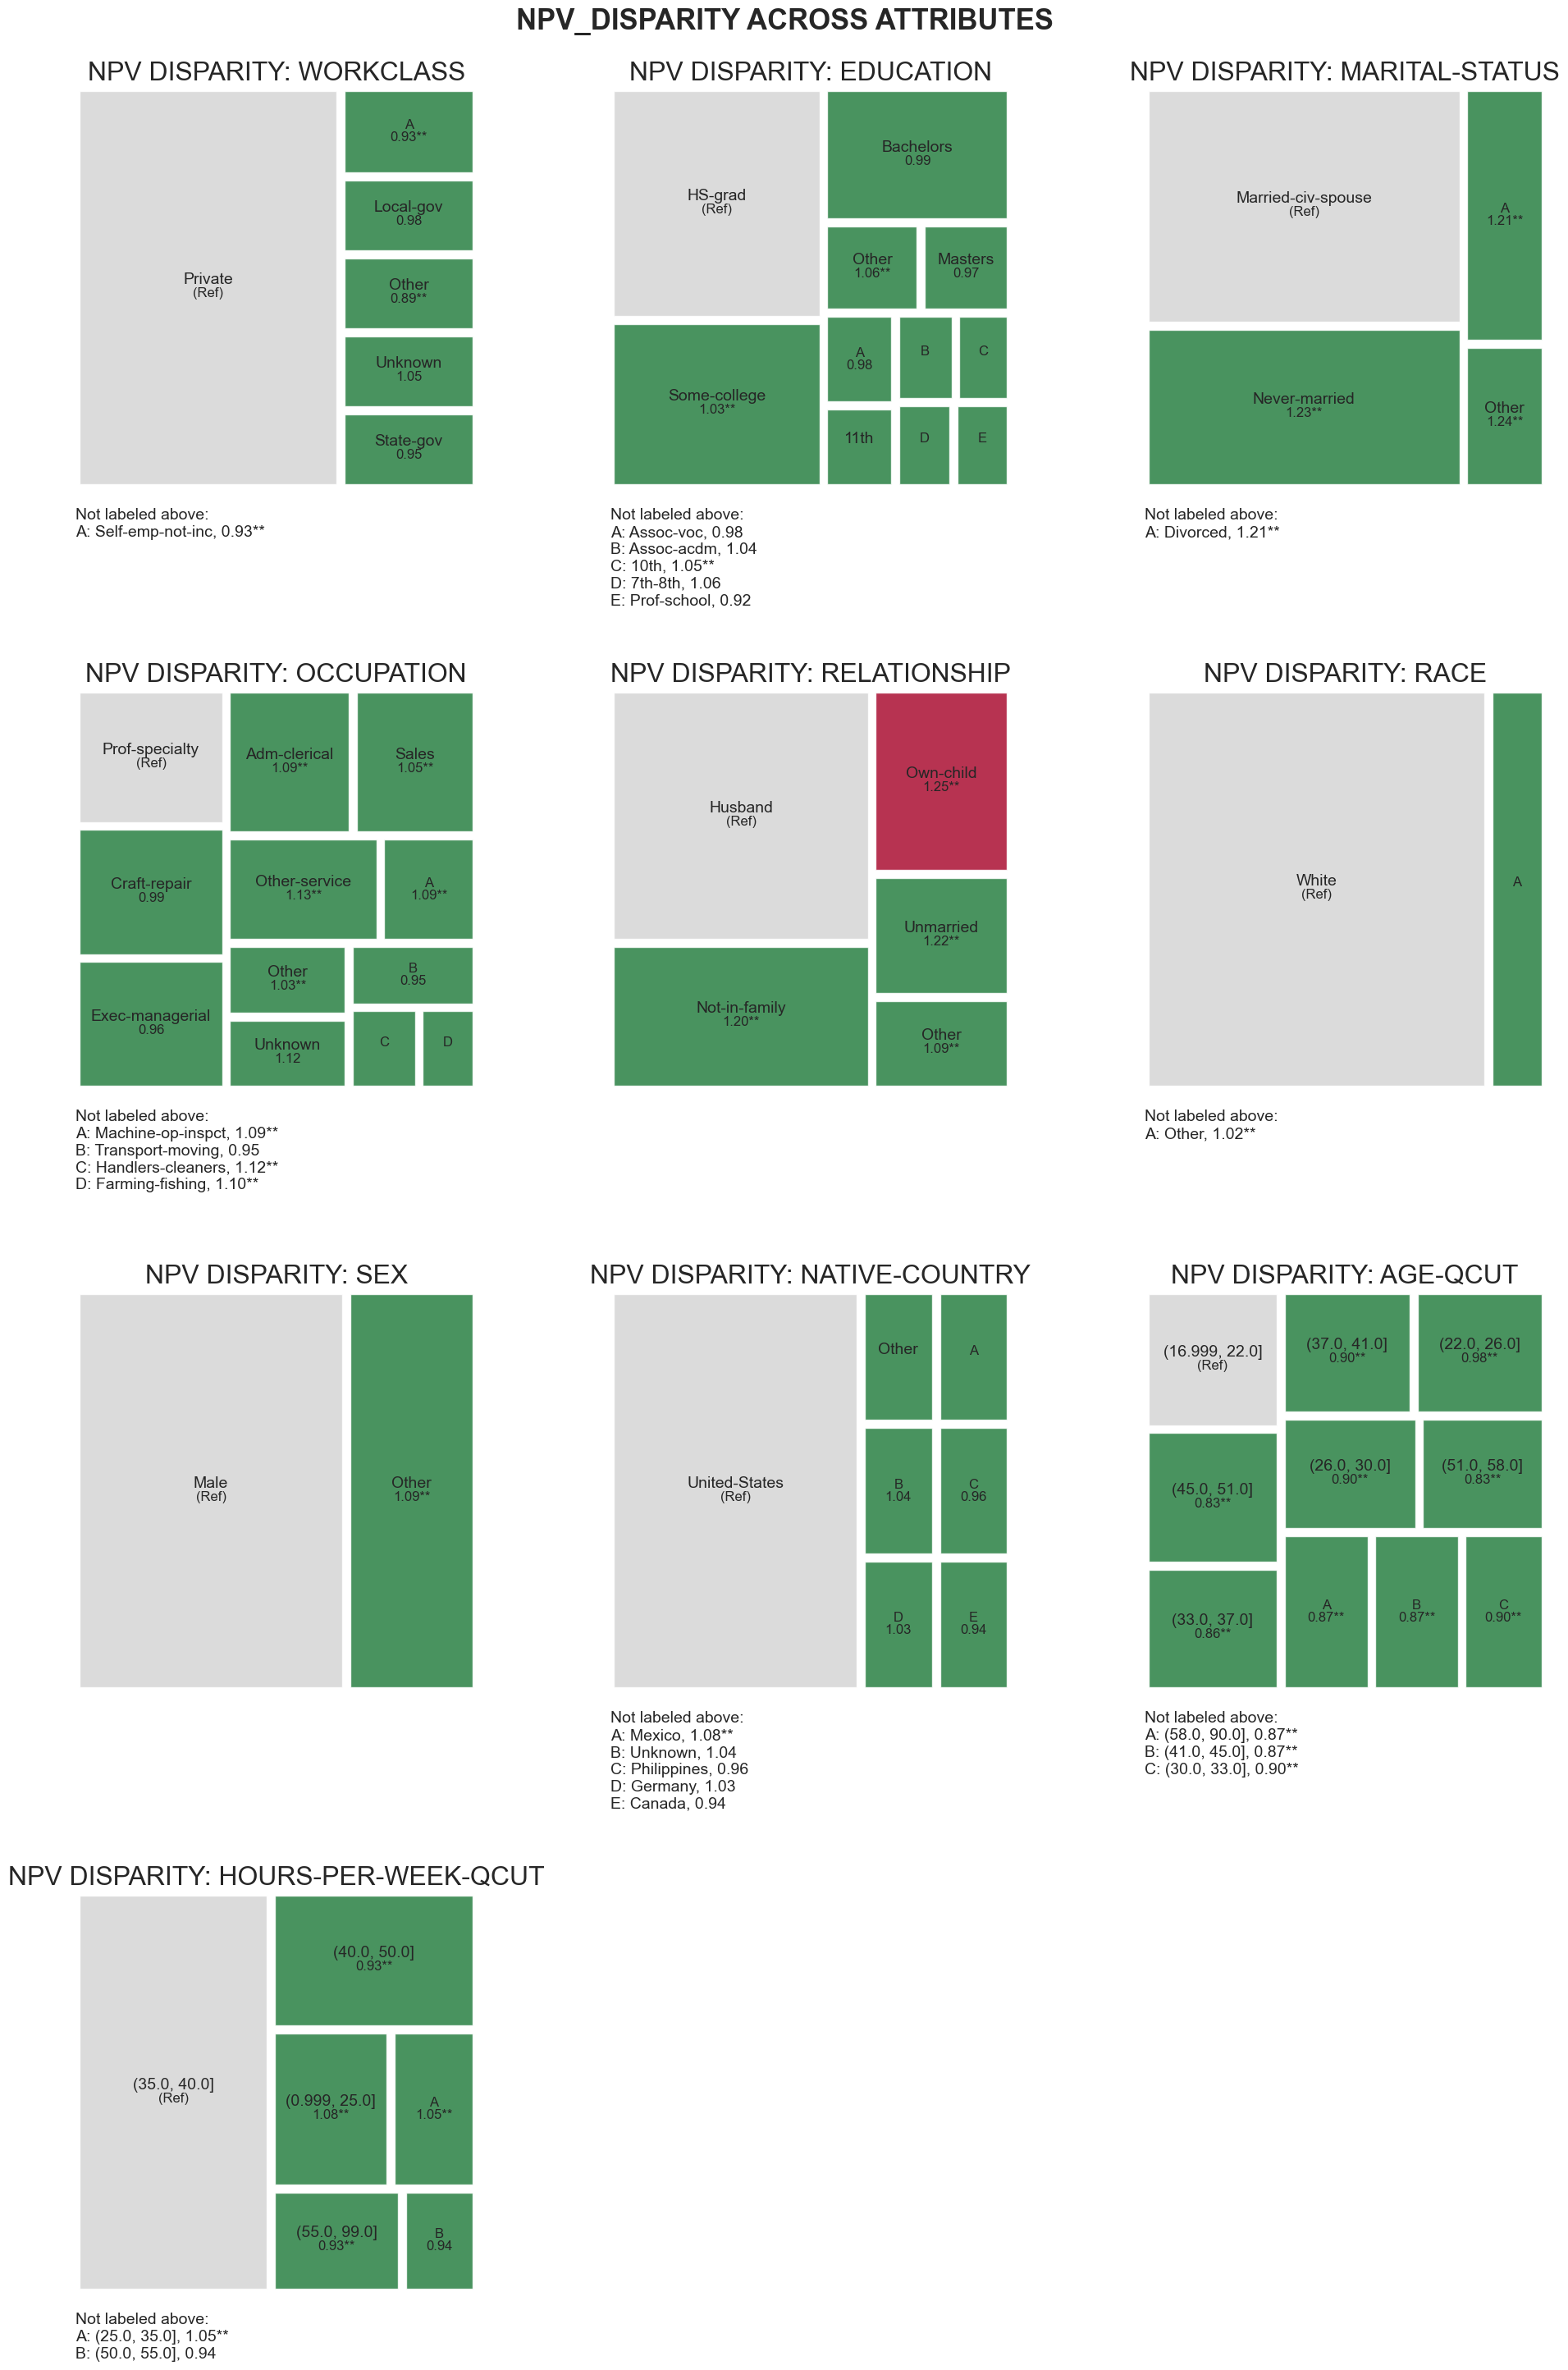

In [230]:
_ = aqp.plot_fairness_disparity_all(bias_df, metrics=[metric + '_disparity'], significance_alpha=0.05)